## Import libraries

In [17]:
import tensorflow as tf
import numpy as np
import os

## Prepare paths of input images and target segmentation masks

In [18]:
input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32
num_filters_list = [32, 64, 128]

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


## Load data paths

In [2]:
import pickle

# Load the list from the file using pickle
def load_paths_file(file_name):
    with open(f"./paths/{file_name}.pkl", "rb") as file:
        paths = pickle.load(file)
    return paths

train_input_img_paths = load_paths_file("train_input_img_paths")
train_target_img_paths = load_paths_file("train_target_img_paths")
val_input_img_paths = load_paths_file("val_input_img_paths")
val_target_img_paths = load_paths_file("val_target_img_paths")
test_input_img_paths = load_paths_file("test_input_img_paths")
test_target_img_paths = load_paths_file("test_target_img_paths")

print("Data paths loaded")

Data paths loaded


## Load datasets

In [20]:
train_dataset_path = 'saved_data/train_dataset'
valid_dataset_path = 'saved_data/valid_dataset'
test_dataset_path = 'saved_data/test_dataset'

# Load datasets
train_dataset = tf.data.Dataset.load(train_dataset_path)
valid_dataset = tf.data.Dataset.load(valid_dataset_path)
test_dataset = tf.data.Dataset.load(test_dataset_path)

print("Datasets loaded.")

Datasets loaded.


## Display functions

In [21]:
from PIL import ImageOps, Image as PILImage
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from IPython.display import display
import matplotlib.pyplot as plt

# Function to display images
def display_images(ground_truth_mask, pred_mask, index):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Ground Truth Mask")
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap='gray')
    plt.axis('off')
    plt.show()
    
# Function to display the predicted mask 
def display_predicted_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(test_preds_array[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(tf.keras.utils.array_to_img(mask))
    display(img)  
    
# Function to display the resized ground-truth target mask 
def display_ground_truth_mask(i):        
    ground_truth_mask = img_to_array(load_img(test_target_img_paths[i], color_mode="grayscale", target_size=img_size))
    ground_truth_mask = np.squeeze(ground_truth_mask, axis=-1)  # Remove the last channel if present
    ground_truth_mask_resized_img = PILImage.fromarray(ground_truth_mask.astype(np.uint8))
    ground_truth_mask_resized_img = ImageOps.autocontrast(ground_truth_mask_resized_img)
    display(ground_truth_mask_resized_img) 

## Dice and IoU scores calculation functions 

In [22]:
# Function to calculate Dice coefficient
def dice_coefficient(y_true, y_pred):
    y_true = tf.keras.backend.cast(y_true, 'float32')
    y_pred = tf.keras.backend.cast(y_pred, 'float32')
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) + 1)

# Function to calculate IoU score
def iou_score(y_true, y_pred):
    y_true = tf.keras.backend.cast(y_true, 'float32')
    y_pred = tf.keras.backend.cast(y_pred, 'float32')
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return (intersection + 1) / (union + 1)

In [23]:
# Function to convert grayscale mask to binary mask
def get_binary_mask(mask, threshold = 1):
    """Convert grayscale mask to binary mask with black background and white object."""
    return (mask > threshold).astype(np.uint8)

# Initialize lists to store scores
def calculate_metrics(test_preds_array):
    iou_scores, dice_scores = [],[]

    # Calculate scores for each image in the test set 
    for i, target_img_path in enumerate(test_target_img_paths):
        # Load and normalize the ground truth mask
        ground_truth_mask = img_to_array(load_img(target_img_path, color_mode="grayscale", target_size=img_size))
        ground_truth_mask = np.squeeze(ground_truth_mask / np.max(ground_truth_mask)).astype(np.uint8)
        
        # Get the model's prediction, resize, and convert to binary
        pred_mask = tf.image.resize(test_preds_array[i], img_size).numpy()
        pred_mask = get_binary_mask(np.argmax(pred_mask, axis=-1))
        
        # Append scores to the lists
        iou_scores.append(iou_score(ground_truth_mask, pred_mask).numpy())
        dice_scores.append(dice_coefficient(ground_truth_mask, pred_mask).numpy())

        # Display the ith's image and masks
        if i == 0:
            display_images(ground_truth_mask, pred_mask, i)
    return iou_scores, dice_scores

# 1. Processing Tensorflow model

## Load model

In [24]:
saved_model_dir = "./saved_models"
os.makedirs(saved_model_dir, exist_ok=True)

model_path = os.path.join(
    saved_model_dir,
    "model_epochs_50_filters_64_with_batch_norm"
)

# Load the model 
model = tf.saved_model.load(model_path)
infer = model.signatures['serving_default']

print("Model loaded.")

Model loaded.


## Perform the prediction on the test dataset

In [25]:
'''This function predicts the dataset in batches'''

# test_preds = []

# for batch in test_dataset:
#     preds = infer(batch[0])  
#     test_preds.append(preds)

# # Convert list of dictionaries to a single dictionary
# final_test_preds = {key: np.concatenate([d[key].numpy() for d in test_preds], axis=0) for key in test_preds[0]}

# # Inspect the keys of the returned dictionary
# print(f"Keys of the test predictions dictionary: {final_test_preds.keys()}")

'This function predicts the dataset in batches'

In [26]:
'''This function predicts the dataset in images'''

import time
import tracemalloc

test_preds, execution_times, peak_lists = [], [], []

# Loop through each batch and image
for batch in test_dataset:
    for img in batch[0]:
        start_time = time.time()
        tracemalloc.start()

        # Prepare input data and perform inference
        input_tensor = tf.expand_dims(img, axis=0)
        try:
            preds = infer(input_tensor)
            test_preds.append(preds)

            # Record time and memory usage
            execution_times.append(time.time() - start_time)
            
            _, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            peak_lists.append(peak / 1024)  # Convert to KB
        except Exception as e:
            print(f"Inference error: {e}")
            continue

# Combine predictions if there are any
if test_preds:
    final_test_preds = {key: np.concatenate([pred[key].numpy() for pred in test_preds], axis=0) for key in test_preds[0]}
    print(f"Prediction keys: {final_test_preds.keys()}")  

Prediction keys: dict_keys(['output_0'])


In [27]:
output_key = 'output_0' 

test_preds_array = final_test_preds[output_key]

In [28]:
# Display average inference time and memory usage per image
print(f"Avg inference time per image: {np.mean(execution_times):.4f} seconds")
print(f"Avg memory usage per image: {np.mean(peak_lists):.4f} KB")

Avg inference time per image: 0.1660 seconds
Avg memory usage per image: 40.4626 KB


## Calculate the Dice and IoU scores

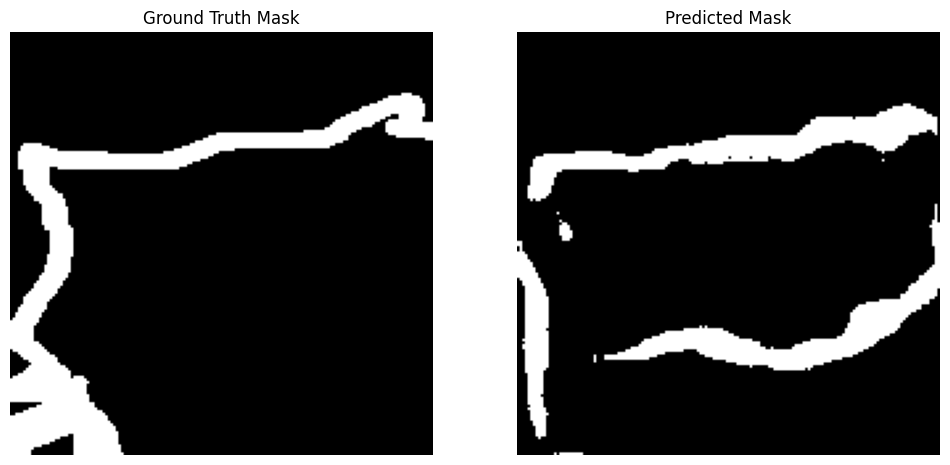

In [29]:
iou_scores, dice_scores = calculate_metrics(test_preds_array)

In [30]:
# Print average scores
print(f"Average Dice Coefficient: {np.mean(dice_scores):.4f}")
print(f"Average IoU Score: {np.mean(iou_scores):.4f}")

Average Dice Coefficient: 0.4767
Average IoU Score: 0.3233


## Display results for a sample image

Dice Coefficient: 0.44425058364868164
IoU Score: 0.28562691807746887


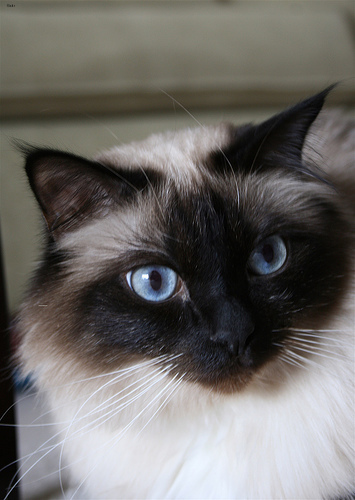

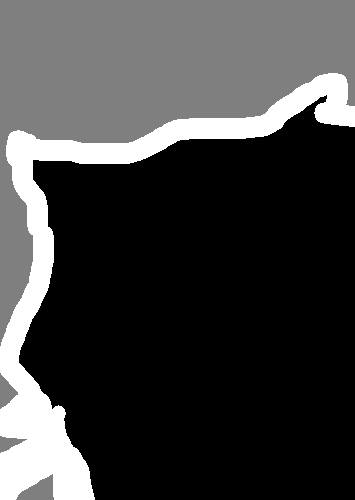

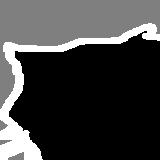

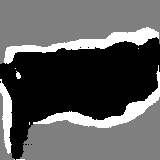

In [31]:
from PIL import ImageOps

# Set the index of the image to display
i = 0

# Print Dice and IoU scores for the selected image
print(f"Dice Coefficient: {dice_scores[i]}")
print(f"IoU Score: {iou_scores[i]}")

# Display the input image
display(PILImage.open(test_input_img_paths[i]))

# Display the original ground-truth target mask 
display(ImageOps.autocontrast(load_img(test_target_img_paths[i], color_mode="grayscale")))

# Display the resized ground-truth target mask 
display_ground_truth_mask(i)

# Display the mask predicted by our model
display_predicted_mask(i)  # This function handles the prediction visualization


# 2. Processing Tensorflow Lite model

## Load model

In [32]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="./saved_models/model_epochs_50_filters_64_with_batch_norm_default.tflite")
interpreter.allocate_tensors()  

# Get input and output details
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

INFO: Created TensorFlow Lite delegate for select TF ops.
2024-08-20 07:31:12.631034: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
INFO: TfLiteFlexDelegate delegate: 3 nodes delegated out of 176 nodes with 3 partitions.

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [33]:
# Initialize an empty list to store predictions
test_preds, execution_times, peak_lists = [], [], []

# Run inference on each image in the test dataset
for batch in test_dataset:
    for img in batch[0]:
        start_time = time.time()
        tracemalloc.start()
        
        # Prepare input data and run inference
        interpreter.set_tensor(input_index, np.expand_dims(img.numpy(), axis=0))
        interpreter.invoke()
        
        # Extract and store the prediction
        test_preds.append(interpreter.get_tensor(output_index))
        # Record time and memory usage
        execution_times.append(time.time() - start_time)
        
        _, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        peak_lists.append(peak / 1024)  # Convert to KB

# Convert the list of predictions to a single numpy array
test_preds_array = np.vstack(test_preds)

In [34]:
# Display average inference time and memory usage per image
print(f"Avg inference time per image: {np.mean(execution_times):.4f} seconds")
print(f"Avg memory usage per image: {np.mean(peak_lists):.4f} KB")

Avg inference time per image: 0.2770 seconds
Avg memory usage per image: 300.6484 KB


## Calculate the Dice and IoU scores

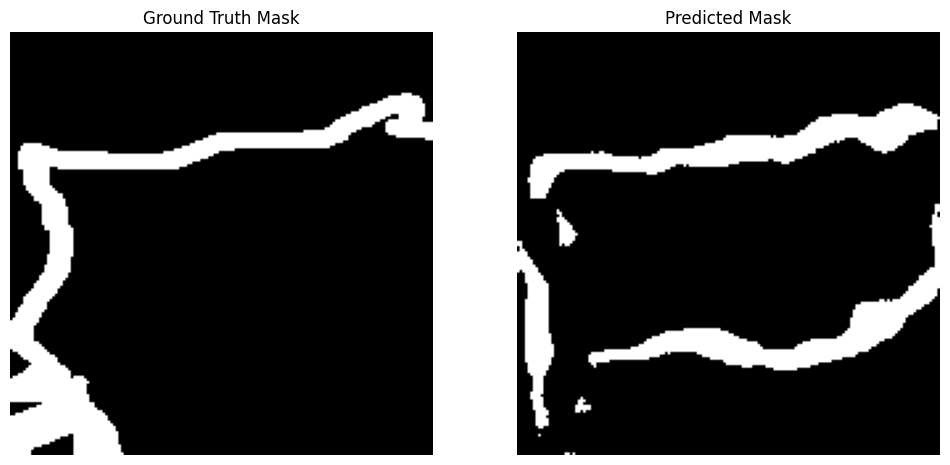

In [35]:
iou_scores, dice_scores = calculate_metrics(test_preds_array)

In [36]:
# Print average scores
print(f"Average Dice Coefficient: {np.mean(dice_scores):.4f}")
print(f"Average IoU Score: {np.mean(iou_scores):.4f}")

Average Dice Coefficient: 0.4778
Average IoU Score: 0.3242


## Display results for a sample image

Dice Coefficient: 0.44078123569488525
IoU Score: 0.28276553750038147


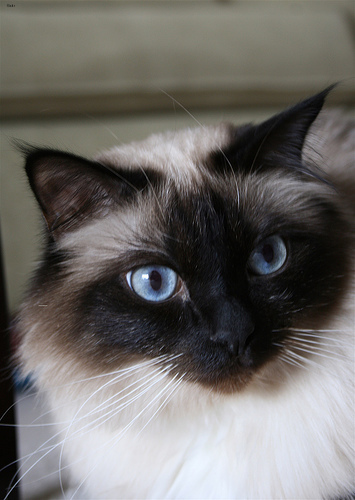

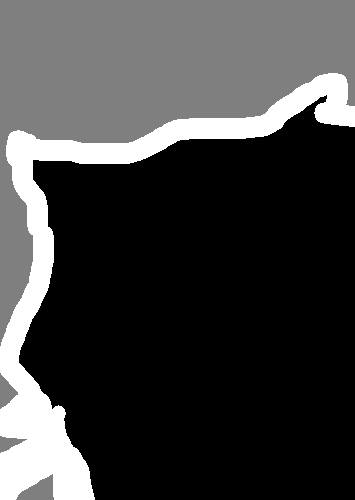

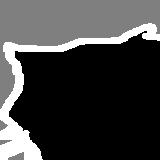

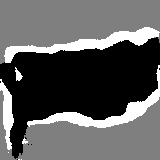

In [37]:
from PIL import ImageOps

# Set the index of the image to display
i = 0

# Print Dice and IoU scores for the selected image
print(f"Dice Coefficient: {dice_scores[i]}")
print(f"IoU Score: {iou_scores[i]}")

# Display the input image
display(PILImage.open(test_input_img_paths[i]))

# Display the original ground-truth target mask 
display(ImageOps.autocontrast(load_img(test_target_img_paths[i], color_mode="grayscale")))

# Display the resized ground-truth target mask 
display_ground_truth_mask(i)

# Display the mask predicted by our model
display_predicted_mask(i)  # This function handles the prediction visualization
